# Eye voxel-based event segmentation using Hidden Markov Models (HMMeye)

---
## Table of contents

1. [**Introduction**](#introduction)

2. [**Movie-viewing analyses**](#movie)  
    2.1. [Import packages](#import)  
    2.2. [Load movie-viewing data](#load)  
    2.3. [Model training](#train)  
    2.4. [Visualize model-training results](#trainviz)  
    2.5. [Model test on movie viewing](#test)

3. [**Recall analyses**](#recall)  
    3.1. [Load recall data](#load2)  
    3.2. [Match model events to human annotation](#eventmatch)  
    3.3. [Model test on recall](#test2)  
    3.4. [Visualize recall results](#recallviz)

<a name="introduction"></a>

## 1) Introduction

This notebook demonstrates the use of a Hidden Markov Model (HMM) for **eye-voxel-based event segmentation** in fMRI data, as described in [Nau et al., 2024](https://doi.org/10.1101/2024.10.19.619187). To run it, please follow the setup steps explained in the [HMMeye GitHub repository](https://github.com/deepmreye/HMMeye), which includes downloading eye-voxel data from [Open Science Framework](https://osf.io/baw39/files).

In brief, we fit an HMM to **eye-voxel data** — the fMRI signal from voxels covering the eyeballs — acquired during naturalistic movie viewing. We then test whether the event boundaries detected from the eye-voxel patterns align with event annotations made by a human observer (**Section 2: Movie-viewing analyses**).

After fitting the model on the movie data, we further test whether the same event structure can be detected in **eye-voxel data collected during recall**, when participants verbally recall the movie while inside the scanner (**Section 3: Recall analyses**).

This approach leverages **magnetic resonance-based eye tracking** to infer gaze-related signals directly from existing fMRI data, without the need for an external camera.

Notebook written by **M. Nau, H. Tarder-Stoll, and C. Baldassano**.

---

Helpful links to get started:

1. [BrainIAK manual on Hidden Markov Models](https://brainiak.org/tutorials/12-hmm/).
2. [HMM tutorial](https://naturalistic-data.org/content/Event_Segmentation.html) by Baldassano, Fleetwood, and Geerligs.
3. [DeepMReye GitHub Repository](https://github.com/DeepMReye/DeepMReye) – supports automated eye-voxel extraction.


<a name="movie"></a>
# 2) Movie-viewing analysis

<a name="import"></a>
## Import packages and useful functions

In [11]:
# packages
import numpy as np
import matplotlib.pyplot as plt
from brainiak.eventseg.event import EventSegment
import h5py
from brainiak.isc import isc
from scipy.stats import zscore, norm
from scipy.signal import find_peaks
import copy
import pickle
from natsort import natsorted

# import useful functions
from importlib import reload
import __utils__ as utils
reload(utils);

<a name="load"></a>
## Load and prepare movie-viewing fMRI data
The following code cell loads the event annotation and the preprocessed eye-voxel data acquired during movie viewing, selects voxels with high inter-subject correlation (ISC), and defines a few helpful variables used later. Note that the [original dataset](https://openneuro.org/datasets/ds001132/versions/1.0.0) by [Chen et al. 2017](https://www.nature.com/articles/nn.4450) used here includes a cartoon clip at the beginning of the scan, which we exclude. Also note that the file 'movie.h5' contains the preprocessed eye-voxel data acquired during movie viewing for all participants (see 'preprocess_eyevoxels.ipynb').

In [ ]:
# event annotations for scene changes in the movie coded as TRs (by Chen et al.)
human_bounds = np.array([  26,  35,  71,  86, 109, 131, 173, 205, 227, 313, 362, 399, 439, 506, 526, 534, 569, 617, 635, 677, 695, 748, 781, 868, 911, \
                        946, 972,1009,1075,1102, 1137,1196,1226,1266,1351,1384,1435,1465,1539,1590, 1664,1690,1703,1735,1800,1827,1855,1899,1937])

# load eye-voxel data (preprocessed using preprocess_eyevoxels.ipynb)
print('- Loading eye-voxel data acquired during movie viewing')
D = h5py.File('data/movie.h5', mode='r')['D'][:] 

# remove cartoon clip at the beginning of the scan
human_bounds = np.delete(human_bounds, [0,26]); human_bounds -= 26; human_bounds[26:] -= 26 # cartoon = 26 TRs
D = np.concatenate((D[26:946,:,:], D[972:,:,:]))

# compute inter-subject correlation for voxel selection
isc_thr = 0.1
sync = isc(D).mean(0)
movie = zscore(D[:,sync > isc_thr], axis=0)

# Useful variables
n_TRs  = np.shape(D)[0]
n_vox  = np.shape(D)[1]
n_subs = np.shape(D)[2]
TR     = 1.5 # seconds
fontsz = 16 # for plotting
print('Done')

<a name="train"></a>
## Model training: Find optimal number of events

The following code cell fits the Hidden Markov Model (HMM) repeatedly to find the optimal number of events in three steps:
1) Fit model with various number of events to half of the participants.
2) Find the number of events that led to the best fit in held-out participants (cross-validation).
3) Fit final model with optimal number of events to the full participant pool.

In [4]:
# Testing generalization across subjs for different numbers of events
n_events = np.array(range(125,150,5)) # sub-selected for speed, original: np.array(range(10,310,5))
test_ll = np.zeros(len(n_events))

print('Model training: find optimal number of events and fit HMM')
for i, k in enumerate(n_events):
    print('- Fitting model with %d events' % k)
    
    # Fitting model on training subjects
    movie_train = movie[:,:,int(n_subs/2):].mean(2)
    movie_HMM = EventSegment(k)
    movie_HMM.fit(movie_train)
    
   # Testing model fit on held-out subjects
    movie_test = movie[:,:,:int(n_subs/2)].mean(2)
    _, test_ll[i] = movie_HMM.find_events(movie_test)

# Fit a final modeo with the best-fitting number of events (k)
best_n_events = n_events[np.argmax(test_ll)]
print('Fitting final model on all subjects with n_events = {}...'.format(best_n_events))
movie_HMM     = EventSegment(best_n_events)
movie_HMM.fit(movie.mean(2))
print('Done')

Model training: find optimal number of events and fit HMM
- Fitting model with 125 events
- Fitting model with 130 events
- Fitting model with 135 events
- Fitting model with 140 events
- Fitting model with 145 events
Fitting final model on all subjects with n_events = 135...
Done


<a name="trainviz"></a>
## Visualize model-training results (sanity check)
The following code cell visualizes the results of the model training. 

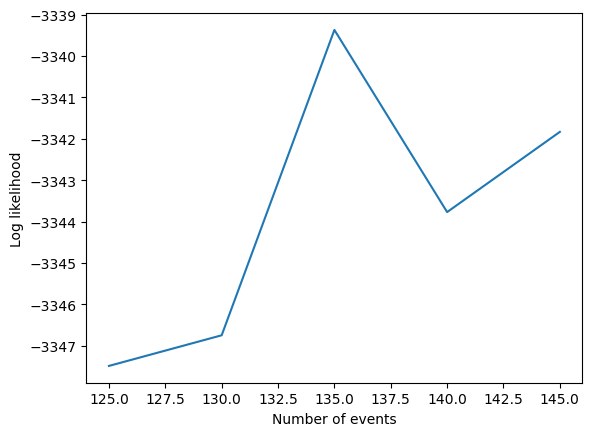

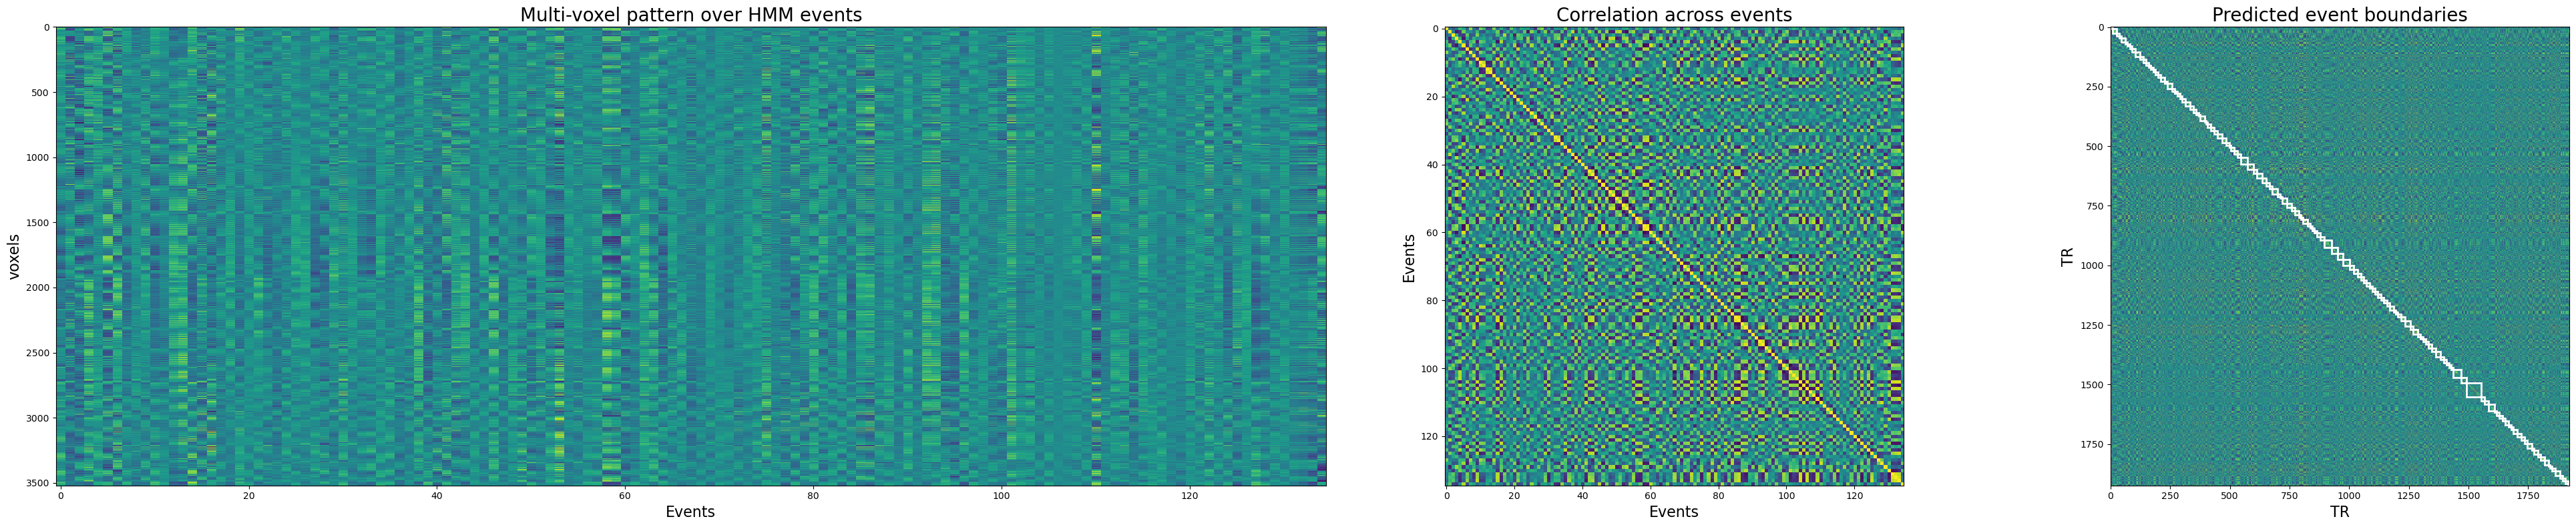

(0.0, 1924.0)

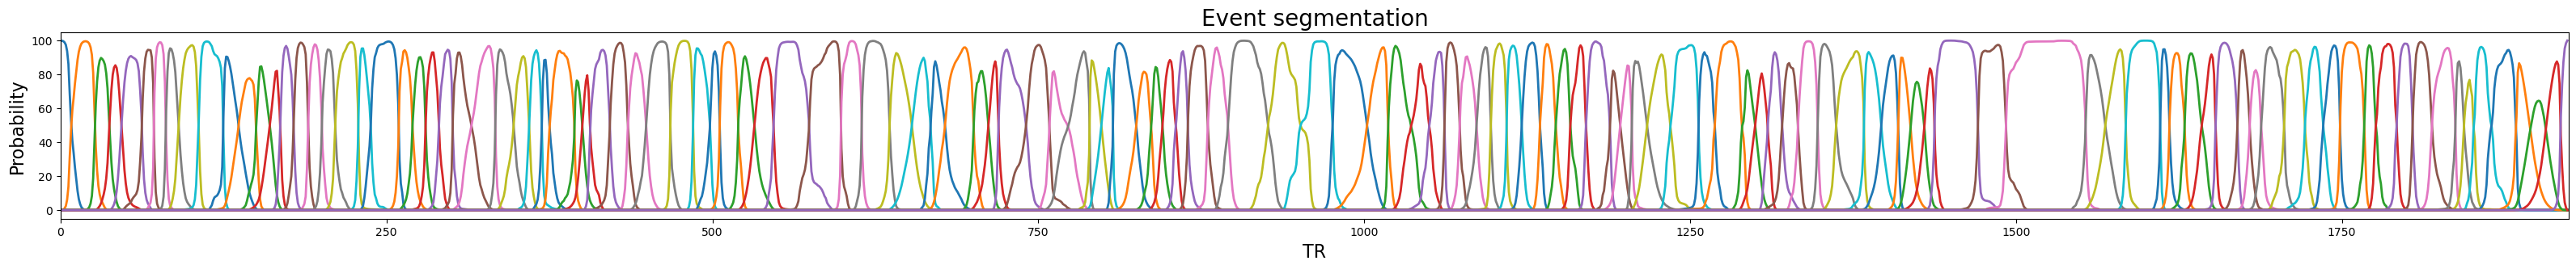

In [8]:
# Figure 1: model LL over event durations
fig = plt.figure
plt.plot(n_events, test_ll)
plt.xlabel('Number of events')
plt.ylabel('Log likelihood')

# Figure 2 - Left panel: eye-voxel patterns across events
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(40, 8), gridspec_kw={'width_ratios': [2, 1, 1]})
ax1.imshow(movie_HMM.event_pat_, aspect="auto", interpolation="none")
ax1.set_title('Multi-voxel pattern over HMM events', fontsize=fontsz*1.25)
ax1.set_ylabel('voxels', fontsize=fontsz); ax1.set_xlabel('Events', fontsize=fontsz)

# Figure 2 - Middle panel: event-by-event multi-voxel pattern correlation matrix
ax2.imshow(np.corrcoef(movie_HMM.event_pat_.T))
ax2.set_title('Correlation across events', fontsize=fontsz*1.25)
ax2.set_ylabel('Events', fontsize=fontsz); ax2.set_xlabel('Events', fontsize=fontsz)

# Figure 2 - Right panel: predicted event boundaries plotted ontop of TR x TR matrix
bounds = np.where(np.diff(np.argmax(movie_HMM.segments_[0], axis=1)))[0]
utils.plot_tt_similarity_matrix(ax3, movie.mean(2).T, bounds, n_TRs, 'Predicted event boundaries', fontsz)
plt.tight_layout()
plt.show()

# Figure 3: event segmentation
plt.figure(figsize=(40,3)); h = plt.gca()
plt.plot(movie_HMM.segments_[0]*100, linewidth = 2)
h.set_title('Event segmentation', fontsize = fontsz*1.25)
h.set_ylabel('Probability', fontsize = fontsz)
h.set_xlabel('TR', fontsize = fontsz)
h.set_xlim(0,movie_HMM.segments_[0].shape[0])

# Figure 4: TRxTR matrix in large
#fig, (ax1) = plt.subplots(1, 1, figsize=(15, 15))  # Figsize is in inches
#bounds = np.where(np.diff(np.argmax(movie_HMM.segments_[0], axis=1)))[0]
#utils.plot_tt_similarity_matrix(ax1, movie.mean(2).T, bounds, n_TRs, 'Predicted event boundaries', fontsz)
#plt.tight_layout()

# Figure 5: Events over TRs
# plt.figure(figsize=(10,10)); plt.imshow(movie_HMM.segments_[0].T, aspect="auto", interpolation="none")

<a name="test"></a>
## Model testing: Compare model-derived event boundaries to human annotation
The following code cell compares the model-derived event boundaries to those previously defined by a human annotator (for details, see [Chen et al. 2017](https://doi.org/10.1038/nn.4450)).

1) Compute the model's event transition strength (or "boundariness") at the human-annotated event boundaries.
2) Shuffle human-annotated boundaries 1000x while keeping event durations constant, and recompute event transition strength each time.
3) Use the shuffled distribution to calculate a zscore and p-value corresponding to the observed event transition strength.
4) Visualize results.

Test statistic: z = 2.842, p = 0.005


Text(0.5, 0, 'Functional volumes')

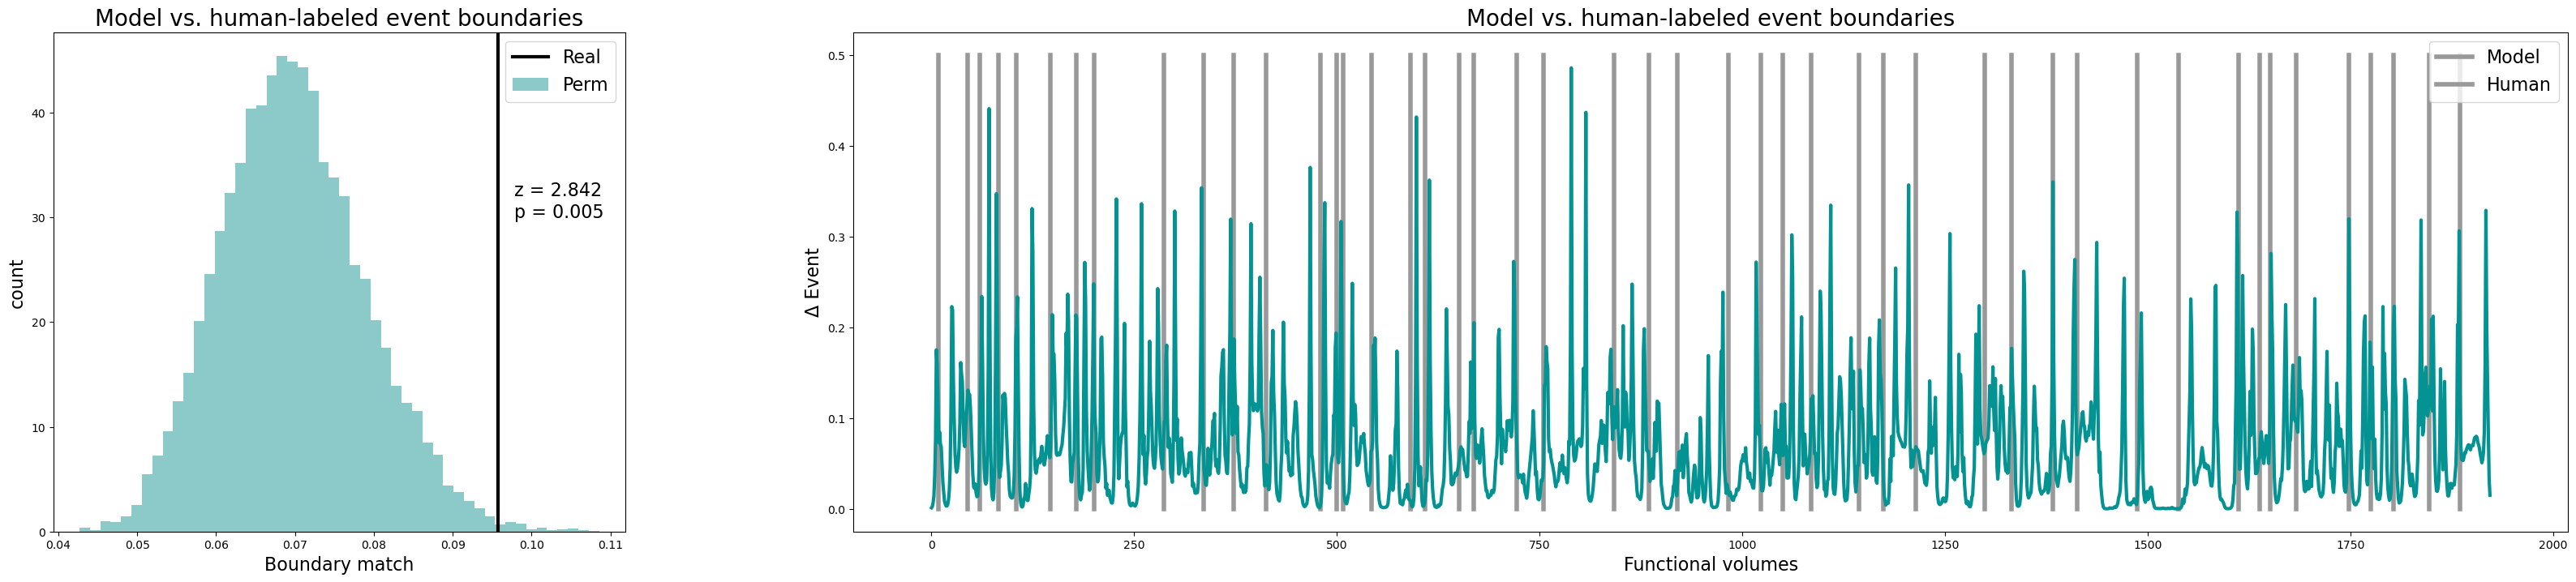

In [ ]:
# Compute observed match between model and human boundaries
boundness = np.diff(movie_HMM.segments_[0]@np.arange(best_n_events))
bound_match = boundness[human_bounds].mean()

# Create shuffle distribution
n_shuffles = 10000
np.random.seed(1)
ev_lengths = np.diff(np.concatenate(([0],human_bounds,[n_TRs])))
perm_bound_match = np.zeros(n_shuffles)
for p in range(n_shuffles):
    perm_bounds = np.cumsum(np.random.permutation(ev_lengths))[:-1]
    perm_bound_match[p] = boundness[perm_bounds].mean()

# compute z-score and p-value
pval = (perm_bound_match >= bound_match).mean()
zval = (bound_match - perm_bound_match.mean())/perm_bound_match.std()
print('Test statistic: z = {:.3f}, p = {:.3f}'.format(zval, pval))

# plot histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 8), gridspec_kw={'width_ratios': [1,3]})  # Figsize is in inches
ax1.hist(perm_bound_match, bins=50, density=True, color = '#8CCACA')
ax1.axvline(x=bound_match, color='k', linewidth = 3)
ax1.set_title('Model vs. human-labeled event boundaries', fontsize=fontsz*1.25)
ax1.legend(['Real','Perm'], fontsize=fontsz)
ax1.set_ylabel('count', fontsize=fontsz); ax1.set_xlabel('Boundary match', fontsize=fontsz)
ax1.text(bound_match+0.002, 30, 'z = {:.3f} \np = {:.3f}'.format(zval, pval), fontsize=fontsz)

# plot model- vs. human-labeled boundaries
for b in human_bounds:
    ax2.plot([b,b],[0,0.5], color=[0.6, 0.6, 0.6], linewidth = 4)
ax2.plot(boundness[:], linewidth=3, color='#049393')
ax2.set_title('Model vs. human-labeled event boundaries', fontsize=fontsz*1.25)
ax2.legend(['Model','Human'], fontsize=fontsz)
ax2.set_ylabel('Δ Event', fontsize=fontsz); ax2.set_xlabel('Functional volumes', fontsize=fontsz)

<a name="recall"></a>
# 3) Recall analysis
All analyses presented so far concerned the fMRI data acquired during movie viewing. The remainder of the notebook will focus on recall analyses (e.g., how to test for evidence of gaze reinstatement in eye-voxel data). Please read [Nau et al. 2024](https://doi.org/10.1101/2024.10.19.619187) for more details and analysis logic. 

<a name="load2"></a>
## Load and prepare recall fMRI data and event annotation
The following code cell loads the preprocessed eye-voxel data acquired during recall as well as the event boundaries for participants' spoken recall. Unlike the movie-viewing data, the recall data is stored in participant-specific files (sub-01.h5, sub-02.h5...) to accomodate differences in recall duration.

In [10]:
# load recall MReye data (masked to the same voxels as the movie data)
print('- Loading eye-voxel data acquired during recall')
recall = []
for subjid in range(16):
    recall_subj = h5py.File('data/sub-%02d.h5' % (1+subjid,), mode='r')['freerecall']['D'][:][sync > isc_thr, :].T
    recall_subj[:,np.any(recall_subj!=0, axis=0)] = zscore(recall_subj[:,np.any(recall_subj!=0, axis=0)], axis=0)
    recall.append(recall_subj)
print('Done')

# load recall event labels for each participant (stored in 'recalled_events.pkl')
recall_bounds = [np.array(i[0]) for i in pickle.load(open('data/recalled_events.pkl', 'rb'))]
recall_bounds = [utils.remove_cartoon_recall(labels) for labels in recall_bounds]

- Loading eye-voxel data acquired during recall
Done


<a name="eventmatch"></a>
## Match model-derived boundaries to human-labeled boundaries

In the data we were working with, the HMM segmented the movie into more events than the human annotator did. The following code cell matches the model events to those of the human annotation (e.g., model event 30-38 may all correspond to human-annotated event 10 etc).

(45,)


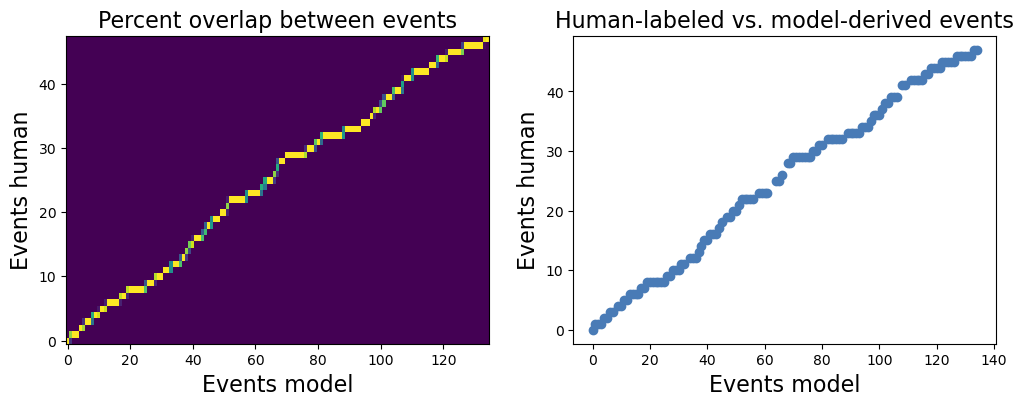

In [ ]:
# Find peaks in boundness
peaks, _         = find_peaks(boundness)
sorted_peaks     = peaks[np.argsort(-boundness[peaks])]
model_boundaries = np.sort(sorted_peaks[:best_n_events-1])

# define onsets and offsets
h_ons  = np.append([0], human_bounds); h_offs = np.append(human_bounds, n_TRs)
m_ons  = np.append([0], model_boundaries); m_offs = np.append(model_boundaries, n_TRs)

# loop over model-derived events
ev_overlap = np.zeros((m_ons.size, h_ons.size))
for ev_m in range(0, m_ons.size):
    m = np.zeros((1,n_TRs))[0]
    m[m_ons[ev_m]:m_offs[ev_m]] = 1

    # loop over human-annotated events
    for ev_h in range(0,h_ons.size):
        h = np.zeros((1,n_TRs))[0]
        h[h_ons[ev_h]:h_offs[ev_h]] = 1

        # compute overlap in percent
        ev_overlap[ev_m, ev_h] = h[m==1].sum() / m.sum()*100

# match model events to human events. Events without sufficient overlap are removed
event_match = np.where(ev_overlap>66.666)

# plot percent overlap
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))
ax1.imshow(ev_overlap.T, aspect='auto', origin='lower')
ax1.set_xlabel('Events model', fontsize=fontsz); ax1.set_ylabel('Events human', fontsize=fontsz)
ax1.set_title('Percent overlap between events', fontsize=fontsz)

# plot final event assignment
ax2.scatter(event_match[0], event_match[1], marker='o', label='Data Points', color='#497BB6')
ax2.set_xlabel('Events model', fontsize=fontsz); ax2.set_ylabel('Events human', fontsize=fontsz)
ax2.set_title('Human-labeled vs. model-derived events', fontsize=fontsz)

<a name="test2"></a>
### Find events in recall data of each participant
Not all participants recalled all events. Events that were not recalled by the participant will be removed from the analysis, such that the HMM only looks for events in the recall data that were actually recalled. It does so in 4 steps: 
1) For each participant, we create a full copy of the trained HMM. 
2) We then remove events that were not recalled from each participants' individualized model. 
3) We compute the log-likelihood for recalled events (i.e., a measure of model fit).
4) We compare the observed log-likelihood to a shuffled distribution. 

In [ ]:
# event shuffling
n_shuffles = 500 # fewer shuffles to speed things up, original: n_shuffles = 5000
n_workers  = 12 # adjust to match your parallel computing setup
event_var  = movie_HMM.event_var_
LL = np.zeros(n_subs)
segment = []
permuteLL = np.zeros((n_subs,n_shuffles))

# loop over participants
print('Model test: finding events in recall data')
for sub in range(n_subs):
    print("\n   Subject:", sub, end='')

    # create participant-specific HMM by selecting the recalled event patterns
    movie_HMM_sub = copy.deepcopy(movie_HMM)
    model_events_recalled = np.where([1 if value in recall_bounds[sub] else 0 for value in event_match[1]])[0]
    movie_HMM_sub.event_pat_ = movie_HMM_sub.event_pat_[:,model_events_recalled]

    # update event_chain & n_events
    movie_HMM_sub.n_events = np.size(movie_HMM_sub.event_pat_,1)
    movie_HMM_sub.event_chains = np.zeros([movie_HMM_sub.n_events])

    # update transition matrix - Probability assumed to be constant across events!
    new_P = np.zeros((movie_HMM_sub.n_events+1, movie_HMM_sub.n_events+1))
    np.fill_diagonal(new_P, movie_HMM_sub.P[0][0]); np.fill_diagonal(new_P[:,1:], movie_HMM_sub.P[0][1]); new_P[-1,-1] = 1
    movie_HMM_sub.P = new_P
 
    # find recalled events
    recall_data = copy.deepcopy(recall[sub])
    subseg, LL[sub] = movie_HMM_sub.find_events(recall_data, var=event_var)
    segment.append(subseg)

    # run shuffles to compute null distribution
    np.random.seed(0)
    print("  ", end='')
    with concurrent.futures.ProcessPoolExecutor(max_workers=n_workers) as executor:
        futures = [executor.submit(utils.find_shuffled_events, movie_HMM_sub, recall_data, event_var) for p in range(n_shuffles)]
        for p, future in enumerate(concurrent.futures.as_completed(futures)):
            permuteLL[sub, p] = future.result()
            if p % 100 == 0:
                print('.', end='')
print('Done')

Model test: finding events in recall data

   Subject: 0  .....
   Subject: 1  .....
   Subject: 2  .....
   Subject: 3  .....
   Subject: 4  .....
   Subject: 5  .....
   Subject: 6  .....
   Subject: 7  .....
   Subject: 8  .....
   Subject: 9  .....
   Subject: 10  .....
   Subject: 11  .....
   Subject: 12  .....
   Subject: 13  .....
   Subject: 14  .....
   Subject: 15  .....

<a name="recallviz"></a>
## Visualize recall results
The following code cell visualizes the recall results and computes the final test statistics (Z-score and p-value relative to the shuffled distribution).

Test statistic: z = 2.851, p = 0.002


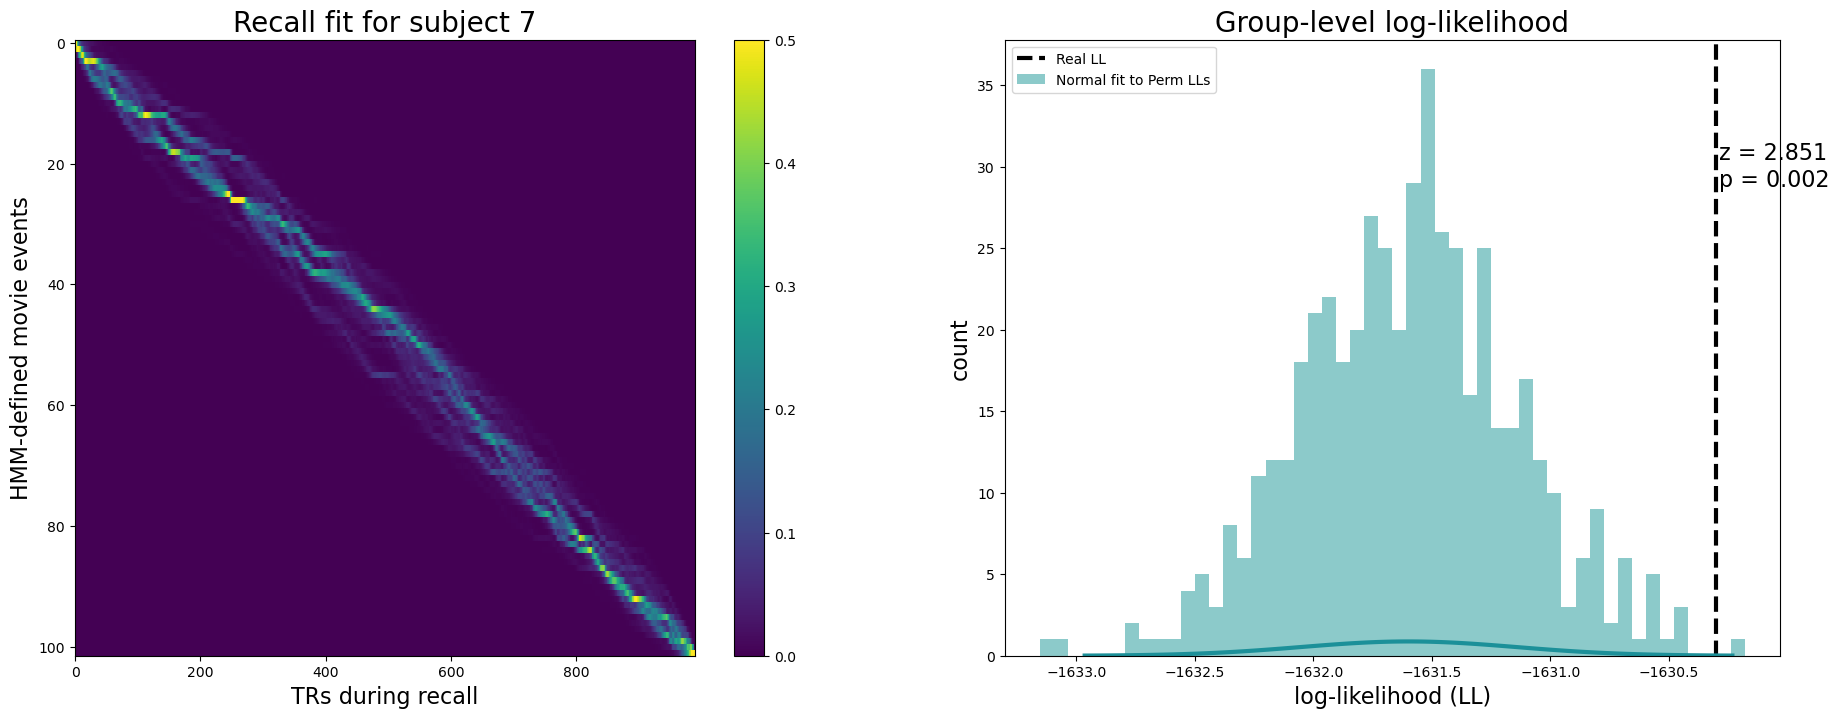

In [15]:
# Figure 1: Recall event prediction for exemplary participant
sub = 6 # select a participant
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8), gridspec_kw={'width_ratios': [1,1]}) 
im = ax1.imshow(segment[sub].T, aspect="auto", interpolation="none", clim=[0,0.5])
ax1.set_title('Recall fit for subject {}'.format(sub+1), fontsize=fontsz*1.25)
ax1.set_xlabel('TRs during recall', fontsize=fontsz)
ax1.set_ylabel('HMM-defined movie events', fontsize=fontsz)
fig.colorbar(im, ax=ax1)

# Figure 2: Histogram of observed LL vs. shuffled LL
mean_LL = LL.mean()
mean_permLL = permuteLL.mean(0)
hist_data = ax2.hist(mean_permLL, bins=50, density=False, color = '#8CCACA')
ax2.axvline(x=mean_LL, color='k', linewidth = 3, linestyle = 'dashed')
ax2.set_title('Group-level log-likelihood', fontsize=fontsz*1.25)
ax2.legend(['Real LL','Normal fit to Perm LLs','Perm LLs',])
ax2.set_ylabel('count', fontsize=fontsz); ax2.set_xlabel('log-likelihood (LL)', fontsize=fontsz)

# Figure 2: Add normal fit
mu = mean_permLL.mean()
sigma = mean_permLL.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, norm.pdf(x, mu, sigma), color = '#1c9099', linewidth = 3)

# compute stats
pval = norm.sf((mean_LL-mu)/sigma)
zval = (mean_LL-mu)/sigma
ax2.text(mean_LL+0.01, np.max(hist_data[0])*0.8, 'z = {:.3f} \np = {:.3f}'.format(zval, pval), fontsize=fontsz)
print('Test statistic: z = {:.3f}, p = {:.3f}'.format(zval, pval))